In [ ]:
# !python --version
# !pip show tensorflow

Python 3.8.20
Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\haldies\miniconda3\envs\tf_env\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [2]:
import tensorflow as tf

In [ ]:
#tes speed internet
# !apt-get install speedtest-cli
# !speedtest-cli


## Impor Library yang Diperlukan

In [5]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Flatten, 
    Conv2D, BatchNormalization, Activation, Input,Reshape, Multiply
)
from tensorflow.keras.regularizers import l2

In [ ]:
import tensorflow as tf

In [3]:
# !pip install tensorflow==2.10.0


In [4]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))

Num GPUs Available:  1


### Load dataset

In [ ]:
# !unzip

In [16]:
dataset_test = '../../dataset_4face/test'
dataset_train = '../../dataset_4face/train'

## Mengecek Keseimbangan Kelas

Jumlah gambar per kategori di folder train:
angry: 3995
happy: 7215
neutral: 4965
sad: 4830

Jumlah gambar per kategori di folder test:
angry: 958
happy: 1774
neutral: 1233
sad: 1247


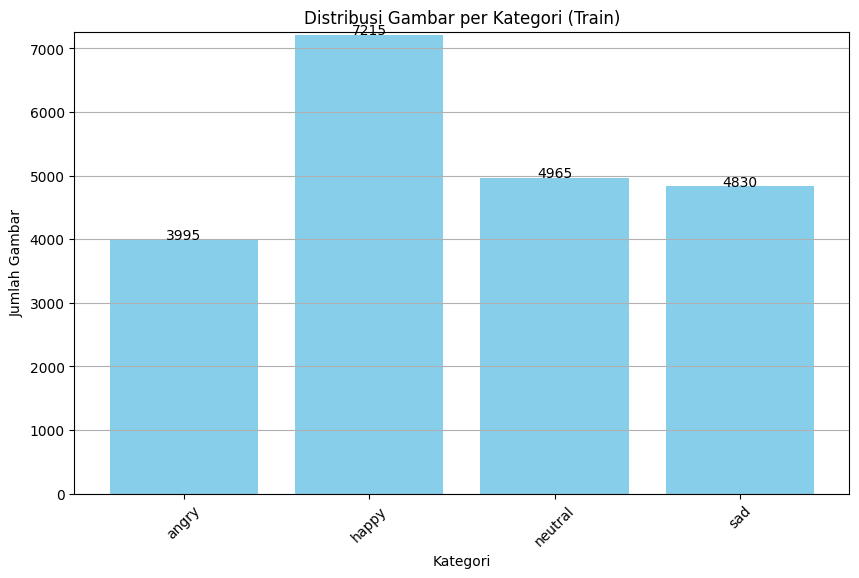

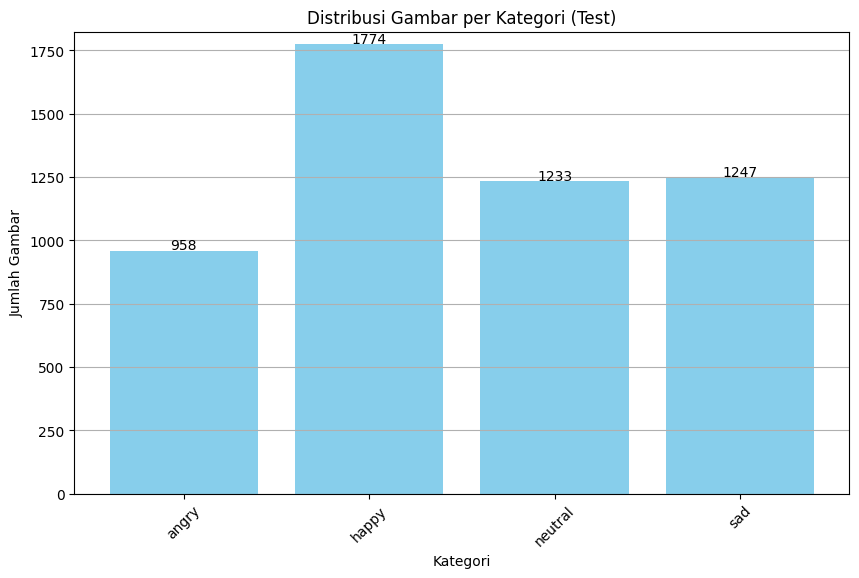

In [17]:
def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    return class_counts


train_counts = count_images_in_directory(dataset_train)
test_counts = count_images_in_directory(dataset_test)


print("Jumlah gambar per kategori di folder train:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nJumlah gambar per kategori di folder test:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")
    
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah Gambar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylim(0, max(counts) + 50)  # Tambah sedikit ruang di atas grafik
    plt.grid(axis='y')

    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center')

    plt.show()
    

plot_class_distribution(train_counts, "Distribusi Gambar per Kategori (Train)")
plot_class_distribution(test_counts, "Distribusi Gambar per Kategori (Test)")


In [21]:

image_size = (48, 48)
batch_size = 64


train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range = 10,
    zoom_range = 0.1,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    directory=dataset_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    # color_mode='grayscale',
    shuffle=True,
    seed=42

)

test_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
)

validation_generator = test_datagen.flow_from_directory(
    directory=dataset_test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    # color_mode = 'grayscale',
    shuffle=True,
    seed=42
)


labels = train_generator.class_indices
print(labels)


total_train_images = train_generator.samples
total_val_images = validation_generator.samples
total_images = total_train_images + total_val_images

print("Total training images:", total_train_images)
print("Total validation images:", total_val_images)
print("Total images in dataset:", total_images)

Found 21005 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}
Total training images: 21005
Total validation images: 5212
Total images in dataset: 26217


In [19]:
images, labels = train_generator.next()

num_images = 9  

plt.figure(figsize=(12, 12))

class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

for i in range(num_images):
 
    ax = plt.subplot(3, 3, i + 1)
    
  
    image = images[i]
    image = np.clip(image, 0, 1)  

    plt.imshow(image.squeeze(), cmap='gray')
    
    label_index = np.argmax(labels[i])  
    label_name = class_labels[label_index]  
    
    plt.title(label_name)
    plt.axis("off")

plt.show()


ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [ ]:
def create_model(input_shape = (48,48,1),num_classes=4):

    input = Input(shape=input_shape)
    x = Conv2D(filters=256,kernel_size=3,activation='relu',padding='same')(input)

    x = Conv2D(filters=512,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    #
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=384,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=192,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)


    x = Conv2D(filters=384,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)

    x = Dense(256,activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dropout(0.3)(x)
    x = Dense(num_classes,activation='softmax')(x)

    return Model(input,x,name='fer_model')


if __name__=='__main__':
    model = create_model()
    model.summary()

Model: "fer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 256)       2560      
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 512)       1180160   
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 512)      2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 512)      0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 512)       0 

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_models.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/50
329/329 [==============================] - 251s 702ms/step - loss: 1.5468 - accuracy: 0.3340 - val_loss: 1.3263 - val_accuracy: 0.3950 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - 85s 259ms/step - loss: 1.3220 - accuracy: 0.4028 - val_loss: 1.2029 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - 85s 259ms/step - loss: 1.1802 - accuracy: 0.4739 - val_loss: 1.1115 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 4/50
329/329 [==============================] - 84s 254ms/step - loss: 1.0551 - accuracy: 0.5400 - val_loss: 1.5034 - val_accuracy: 0.2920 - lr: 0.0010
Epoch 5/50
329/329 [==============================] - 84s 254ms/step - loss: 0.9796 - accuracy: 0.5771 - val_loss: 0.9145 - val_accuracy: 0.6059 - lr: 0.0010
Epoch 6/50
329/329 [==============================] - 83s 252ms/step - loss: 0.9323 - accuracy: 0.6011 - val_loss: 0.8701 - val_accuracy: 0.6318 - lr: 0.0010
Epoch 7/50
329/329 [==============================]

In [26]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {test_accuracy:.2f}')

82/82 [==============================] - 5s 59ms/step - loss: 0.6689 - accuracy: 0.7364
Test accuracy: 0.74


In [16]:
model.save('modelV2.h5')

In [27]:
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.models import load_model

# model = load_model('modelV2.h5')

labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(predictions, axis=1)

report = classification_report(labels, y_pred, target_names=class_labels)
print(report)


82/82 [==============================] - 5s 59ms/step
              precision    recall  f1-score   support

       angry       0.18      0.15      0.16       958
       happy       0.36      0.36      0.36      1774
     neutral       0.23      0.28      0.25      1233
         sad       0.24      0.21      0.23      1247

    accuracy                           0.27      5212
   macro avg       0.25      0.25      0.25      5212
weighted avg       0.27      0.27      0.27      5212



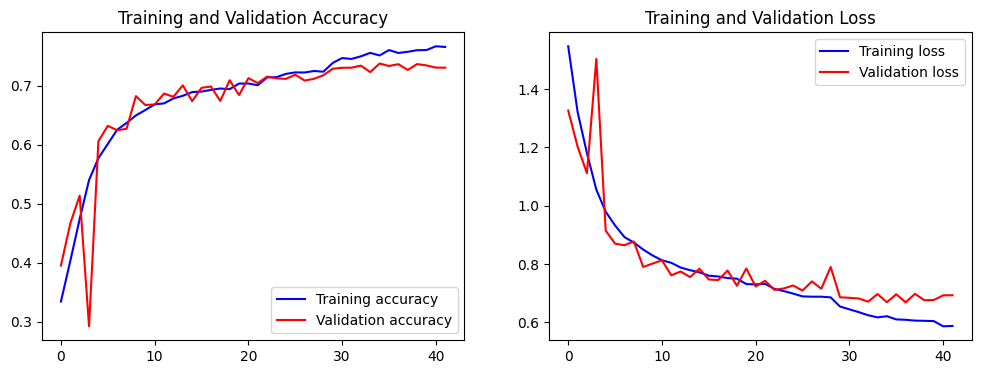

In [28]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_training_history(history)

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

img_width, img_height, img_depth = 48, 48, 3
num_classes = len(labels)

base_model = ResNet50(
    input_shape=(img_width, img_height, img_depth),
    include_top=False,
    weights="imagenet"  # Bisa diganti dengan pretrained di dataset wajah
)

# Freeze Layers
for layer in base_model.layers[:-10]:  # Fine-tune lapisan terakhir saja
    layer.trainable = False

# Custom Head for FER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

# Define Model
model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Summary
model.summary()


94765736/94765736 [==============================] - 80s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                            

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_training_history(history)

Note belajar Grad Cam 

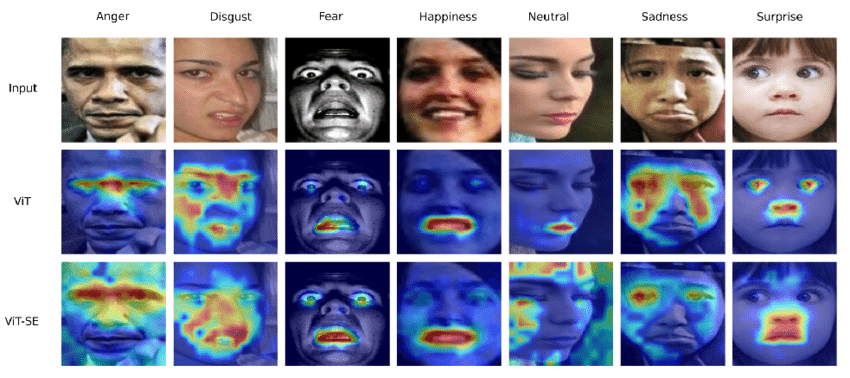